# 2024Q1报告

使用em的业绩报告数据。

In [146]:
import pandas as pd
from scipy.stats import zscore
import akshare as ak
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import numpy as np
from IPython.display import HTML
import sqlite3
from pathlib import Path
import datetime
from uuid import uuid4
from scipy import stats


In [147]:
# 解决matplotlib的中文问题
# bash中使用fc-list 找到family name
# plt.rcdefaults() # 样式调乱了，需要用它重置一下。
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)
# 设置全局字体为
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('ggplot')

In [148]:
# def begin with plot, always use widedf
# def begin with draw, always use other df

def showProfile(df) :
    col_profile = pd.concat([df.dtypes, df.isna().sum()/len(df)*100, df.sample().T], axis=1 ).reset_index()
    col_profile.columns = ['列名', '类型', '缺失比%','样例']
    return (col_profile)

def plot_barh(df, title=None, fmt=''):
    """
    plot barh, x axis on top. If title not set, use df.columns[0] as title.
    """
    height = len(df)*25/72+0.5
    ax = df.plot.barh(figsize=(10, height), width=0.8, legend=False, zorder=3)
    ax.bar_label(ax.containers[0], label_type='edge', fmt=fmt)
    ax.xaxis.tick_top()
    title = title if title else df.columns[0]
    ax.set_title(title, fontsize=16, pad=20)
    
    plt.show(ax)

def df_cards(df, cols=None):
    """
    把df的每一行转化为html卡片形式。
    df: 整理好的DataFrame
    cols: 要展示的列名列表，需要在调用前进行修改。确定需要展示的样式：title, big, item, content等， 如果不提供，默认使用df的列名。
    """
    if not cols:
        cols = df.columns
    df.columns = [i for i in range(len(df.columns))]
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('cards.html')
    html_out = template.render(cols=cols, df=df)

    return HTML(html_out)

def plot_desc(df:pd.DataFrame):
    """
    x is time axis
    """
    df = df.T
    df = pd.concat([df.mean(), df.median(), df.max(), df.min()], axis=1)
    df.columns = ['mean', 'median', 'max', 'min']
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    df.iloc[:,[0,1]].plot(kind='line', ax=axs[0])
    df.iloc[:,[2,3]].plot(kind='line', ax=axs[1])
    plt.tight_layout()
    plt.show()

def plot_labs(df: pd.DataFrame, oneline:bool = False):
    """
    将df输出为包含三个值title, value, rank的标签。
    df: 二列或者三列，第一列为cname, 第二列为值，第三列可为其它数，如果没有第三列，则创建第三列为rank
    """
    uid = uuid4()
    if len(df.columns) == 2:
        df = df.reset_index(drop=True)
        df['rank'] = df.index+1
    codes = pd.read_csv('codes.csv', dtype={'code':'str'})[['cname', 'code']]
    df = df.merge(codes, on='cname')
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template('lab.html')
    html_out = template.render(df=df, oneline = oneline, uid = uid)
    return HTML(html_out)

def plot_subs(df:pd.DataFrame, cols:int, kind:str = 'barh', sharex:bool = True, sharey:bool = True):
    """
    plot subplot.
    df: must be tidied, keep only data cols
    cols: how many columns in the subplots
    """
    s = df.shape
    rows = int(s[1]/cols)+1
    lay = (rows, cols)
    height = s[0]*0.3*rows
    axs = df.plot(kind=kind, subplots=True, layout=lay, figsize=(10,height), sharex=sharex, sharey=True, fontsize=8, legend=False)
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def plot_muti_lines(df: pd.DataFrame, logy:bool = False):
    """
    multiline chart
    legend order by last column, and in left side.
    """
    height = max(0.3*len(df.T), 5)
    ax = df.plot.line(figsize=(10, height), logy=logy)
    handles, labels = ax.get_legend_handles_labels()
    # h = list(df.iloc[-1].sort_values(ascending=False).index.values)
    ol = list(df.iloc[-1].sort_values(ascending=False).index.values)
    oh = [handles[labels.index(label)] for label in ol]
    ax.legend(oh, ol, loc='upper left')
    plt.show(ax)

def plot_cdf(df:pd.DataFrame, col:int = -1, logx : bool = False):
    x = df.iloc[col, :].sort_values()
    y = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x, y)
    if logx:
        ax.set_xscale('log')  # 设置 x 轴为对数轴
    ax.twinx().set_ylim(0, len(x))

    plt.show()

def plot_total_change(df:pd.DataFrame, fmt:str = '{:.2f}'):
    """
    df: index is year, columns is cname.
    return barh with 2 axes.
    share y axis which is year.
    x axis is total, pct change.
    """
    height = 0.3*len(df)+1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, height), sharey=True)
    df.T.sum().plot.barh(ax=ax1, width=0.8, title='Total')
    df.T.sum().pct_change().plot.barh(width=0.8, title = 'Pct Change')
    ax1.bar_label(ax1.containers[0], fmt=fmt)
    ax2.bar_label(ax2.containers[0], fmt='{:.2%}')
    plt.tight_layout()
    plt.show()

def draw_vhists(df:pd.DataFrame, bins:int = 14, fig_cols:int =3):
    """
    df: must be tidied, keep only numeric data cols only.
    fig_cols: how many columns in the subplots
    """
    def divide_or_ceil(a:int, b:int):
        if a % b == 0:
            return a // b
        else:
            return (a // b) + 1
    df_cols = len(df.columns)
    rows = divide_or_ceil(df_cols, fig_cols)
    height = 0.3*bins*rows+1
    fig, axs = plt.subplots(rows, fig_cols, figsize=(10,height))
    axs = axs.flatten()
    for i in range(df_cols):
        axs[i].hist(df.iloc[:,i], bins=bins, edgecolor='white', linewidth=1.2, orientation='horizontal')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()

def cross_dfs(df:pd.DataFrame, to_cross:list):
    """
    求出若干个df的交集，每个df都有cname列。
    """
    res = set(df['cname'])
    for d in to_cross:
        res &= set(d['cname'])
    ret_df = df[df['cname'].isin(res)]
    return ret_df

def de_banks(df:pd.DataFrame):
    ret = df[~df['cname'].str.contains(r'银行|商行|证券')]
    print(f'total: {len(df)} | banks: {len(df)-len(ret)} | non-banks: {len(ret)}')
    return ret

def get_slope(s:pd.Series):
    y = s.values  # y 值为序列的值
    x = np.arange(len(y))  # x 值为序列的索引
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    # 计算残差
    y_pred = slope * x + intercept
    residuals = y - y_pred
    # 计算残差的标准差（Residual Standard Error）
    residual_std_dev = np.std(residuals)
    ret = slope / (residual_std_dev + 1e-10)  # 避免除以零
    return ret

def cross_index(ss):
    crossed = set(ss[0].index)
    for s in ss[1:]:
        crossed = crossed & set(s.index)
    return ss[0].loc[list(crossed)]

In [149]:
class YJBB:
    ALL_COLS = ['序号', '股票代码', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长', '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量', '销售毛利率', '所处行业', '最新公告日期']
    
    def __init__(self, q:str = '1231'):
        self.df = self.get_data(q)
        self.indu_dict = self.df.groupby('cname')['industry'].first().to_dict()
        self.codedf = self.get_codes()
        self.code_dict = self.get_code_dict()

    def get_data(self, q:str = '1231'):
        cols = ['股票代码', '股票简称', '每股收益', '营业收入-营业收入','净利润-净利润', '每股净资产', '净资产收益率', '每股经营现金流量', '所处行业', 'rdate']
        cols_str = ', '.join([f'"{col}"' if '-' in col else col for col in cols])
        conn = sqlite3.connect('../yjbb.db')
        df = pd.read_sql_query(f'select {cols_str} from yjbb_data where substr(rdate, -4) = "{q}"', conn)
        conn.close()
        df.columns = ['code', 'cname', 'eps', 'revenue', 'profit', 'bvps', 'roe', 'ocf', 'industry', 'rdate']
        qs = {'1231': 'Q4', '0331': 'Q1', '0630': 'Q2', '0930': 'Q3'}
        df['rdate'] = df['rdate'].str[2:4]+qs[q]
        df.replace(0, np.nan, inplace=True)
        df['share'] = df['profit'] / df['eps']
        df['asset'] = df['profit'] * 100 / df['roe']
        df['cash'] = df['ocf'] * df['share']
        df['npm'] = df['profit'] / df['revenue']
        df['cfr'] = df['cash'] / df['revenue']
        df = df[['code', 'cname', 'rdate', 'industry','revenue', 'profit', 'eps','asset', 'cash', 'npm', 'roe', 'cfr']]
        return df
    
    def get_codes(self):
        current_time = datetime.datetime.now().timestamp()
        codes = Path('codes.csv')
        if codes.exists() :
            diff = current_time - codes.stat().st_mtime
            if diff < 3600*24:
                df = pd.read_csv(codes, dtype={'code': str})
                return df
        df = ak.stock_zh_a_spot_em()[['代码', '名称','市盈率-动态', '市净率', '总市值']]
        df.columns = ['code', 'cname', 'pe', 'pb', 'mv']
        df.to_csv(codes, index=False)
        return df
    
    def get_code_dict(self):
        codes = self.codedf
        codes['link'] = codes['code'] + codes['cname']
        codes['link'] = codes['link'].apply(lambda x: f'<a href="https://data.eastmoney.com/stockdata/{x[0:6]}.html" target="_blank">{x[6:]}</a>')
        code_dict = codes.set_index('cname')['link'].to_dict()
        return code_dict
        
    def wide_df(self, df:pd.DataFrame, df_col: str):
        """
        去除新三板的数据，去除报告有异常空值的数据。
        返回整理好的数据。行为期数，列为股票代码，值为数据。
        """
        # df = self.df if not df else df
        tdf = df.pivot_table(index='rdate', columns='cname', values=df_col, aggfunc='first')
        a_code = self.codedf['cname']
        use_code = list(set(tdf.columns) & set(a_code))
        # 去除中间有空值的代码
        tdf = tdf[use_code]
        rdate_idx = tdf.index
        tdf = tdf.reset_index(drop=True)
        first_nonull_index = list(tdf.apply(lambda col: col.first_valid_index()))
        null_counts = tdf.isnull().sum().to_list()
        mask = [False if null_counts[i] > first_nonull_index[i] else True for i in range(len(null_counts))]
        widedf = tdf[tdf.columns[mask]]
        widedf.index = rdate_idx
        return widedf
    
    def get_mostn(self, df:pd.DataFrame, n:int=300, ascending:bool = False):
        """
        input df: widedf, index by year.
        return df: any cname appeared in top n in any year.
        num: how many times appeared.
        tnum: total reports.
        pct: hit times of total reports.
        """
        mostn_per_year = df.T.apply(lambda x: x.sort_values(ascending=ascending).head(n).index)
        mostn_all = mostn_per_year.melt()['value'].value_counts().to_frame('hits')
        total_reports = df.count().to_frame('total')
        mostn_all = mostn_all.merge(total_reports, left_index=True, right_index=True)
        mostn_all['pct'] = mostn_all['hits'] / mostn_all['total']
        mostn_all = mostn_all.sort_values(by=['pct', 'total'], ascending=[ascending, ascending])
        return (mostn_per_year, mostn_all)
    
    def mostn_by_func(self, df:pd.DataFrame, mostn:int = 300, ascending:bool = False, no_sum:bool = False):
        # for func in ['sum', 'mean', 'median', 'min', 'max']:
        funcs = ['mean', 'median', 'min', 'max'] if no_sum else ['sum', 'mean', 'median', 'min', 'max']
        res = [ df.agg(func).sort_values(ascending=ascending).to_frame(func).head(mostn).index.values for func in funcs]
        ret = pd.DataFrame(res).T
        ret.columns = funcs
        ret = ret.map(lambda x: self.code_dict[x]).style
        return ret
    
    def gt_all_years(sefl, df:pd.DataFrame, low:int = 10, high:int = 16):
        """
        find all companies that have been greater than n in all years
        """
        res = pd.DataFrame({
            n: (df > n).sum() for n in range(low, high)
        })
        total_s = df.count()
        res = res[res.apply(lambda x : x == total_s)]
        cols = [f'{v} gt {k}' for k, v in res.count().items()]
        res.columns = cols
        res.index = res.index.map(lambda x: yjbb.code_dict[x])
        res = res.sort_values(by=cols[0], ascending=False)
        return res
    
    def gt_per_year(self, df:pd.DataFrame, n:int = 15):
        """
        plot barh of count of companies that have been greater than n in each year
        """
        s = (df > n).sum(axis=1)
        total = df.count(axis=1)
        res = s.to_frame(f'count great than {n}')
        res['pct'] = res[f'count great than {n}'] / total
        plot_subs(res,2, sharex=False)

    def fold_a_col(self, s:pd.Series, n:int = 10, show_num:bool = True, fmt = '{:.2f}'):
        """
        fold a column into n columns
        input series must be indexed by cname, and values are numbers
        output: cname + value in every cell
        """
        df = s.dropna().sort_values(ascending=False).to_frame()
        if show_num:
            df['cname'] = df.index.map(lambda x: self.code_dict[x]) + ' ' + df.iloc[:,-1].map(lambda x: fmt.format(x))
        else:
            df['cname'] = df.index.map(lambda x: self.code_dict[x])
        df['group'] = [i % n for i in range(len(df))]
        folded = pd.concat([g.reset_index(drop=True)[['cname']] for _, g in df.groupby('group')], axis=1)
        folded.columns = [i+1 for i in range(n)]
        folded.replace(np.nan, '', inplace=True)
        print(f'total: {len(df)} | from {round(df.iloc[:,0].max(), 2)} to {round(df.iloc[:,0].min(), 2)}')
        return folded.style
    
    def indu_count(self, s:pd.Series, n:int = 20):
        indu = s.map(lambda x: self.indu_dict[x])
        indu_count = indu.value_counts().sort_values(ascending=True)
        print(f'total: {len(indu_count)} | top {n} : {indu_count.tail(n).sum() / indu_count.sum() * 100:.2f}%')
        plot_barh(indu_count.tail(n).to_frame('count'))


yjbb = YJBB('0331')

In [150]:
def tops():
    cols = ['revenue', 'profit', 'asset', 'cash']
    widedfs = [yjbb.wide_df(yjbb.df, df_col=df_col) for df_col in cols]
    top20 = pd.DataFrame([yjbb.get_mostn(x, 20)[0].iloc[:, -1] for x in widedfs]).T
    top20.columns = cols
    top20_style = top20.map(lambda x: yjbb.code_dict[x]).style
    top300s = [yjbb.get_mostn(x)[1] for x in widedfs]

    def top300_info():
        for i in range(len(cols)):
            print(f'{cols[i]} top 300: {len(top300s[i])}')
        anytime_corossed = cross_index(top300s)
        print(f'top 300 in all cols: {len(anytime_corossed)}')
        display(yjbb.fold_a_col(anytime_corossed.iloc[:,0], show_num=False))

    def alltime_top300():
        always_top300 = [x[x['pct'] == 1] for x in top300s]
        for i in range(len(cols)):
            always_top300[i].index.name = cols[i]
            print(f'{cols[i]} all time top 300: {len(always_top300[i])}')
            display(yjbb.fold_a_col(always_top300[i].iloc[:,0], show_num=False))
        
        all_time_no_cash = cross_index(always_top300[:-1])
        print(f'all time top 300 no cash: {len(all_time_no_cash)}')
        display(yjbb.fold_a_col(all_time_no_cash.iloc[:, 0], show_num=False))

        alltime_corossed = cross_index(always_top300)
        print(f'all time top 300 in all cols: {len(alltime_corossed)}')
        display(yjbb.fold_a_col(alltime_corossed.iloc[:,0], show_num=False))
        return all_time_no_cash

    def top_slope():
        slope_sl = [x.loc[:,x.count() > 6].apply(get_slope).sort_values(ascending=False) for x in widedfs]
        top20_df = pd.DataFrame([x.head(20).index for x in slope_sl]).T
        top20_df.columns = cols
        slope_top20_style = top20_df.map(lambda x: yjbb.code_dict[x]).style
        display(slope_top20_style)
        top300_sl = [x.head(300) for x in slope_sl]
        crossed_s_nocash = cross_index(top300_sl[:-1])
        crossed_s_all = cross_index(top300_sl)
        print(f'slope top 300 no cash: {len(crossed_s_nocash)}')
        display(yjbb.fold_a_col(crossed_s_nocash, show_num=False))
        print(f'slope top 300 in all cols: {len(crossed_s_all)}')
        display(yjbb.fold_a_col(crossed_s_all, show_num=False))
        return crossed_s_nocash

    return (top20_style, top300_info, alltime_top300, top_slope)

In [151]:
def totals():
    # get sum of [revenue, profit, asset, cash] of each year
    sum_df = yjbb.df.groupby('rdate').sum()[['revenue', 'profit', 'asset']]
    plot_muti_lines(sum_df, logy=True)
    plot_muti_lines(sum_df.pct_change(), logy=False)
    sum_df['npm'] = sum_df['profit'] / sum_df['revenue'] * 100
    sum_df['roe'] = sum_df['profit'] / sum_df['asset'] * 100
    plot_muti_lines(sum_df[['npm', 'roe']], logy=False)

## 金额

### 总体情况

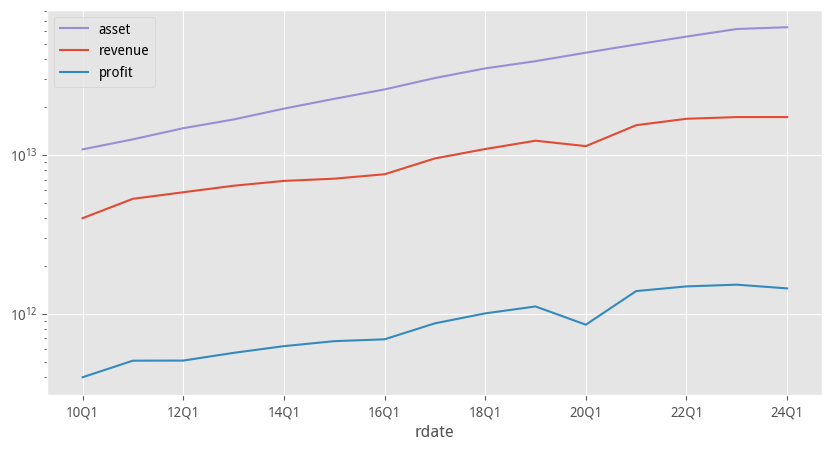

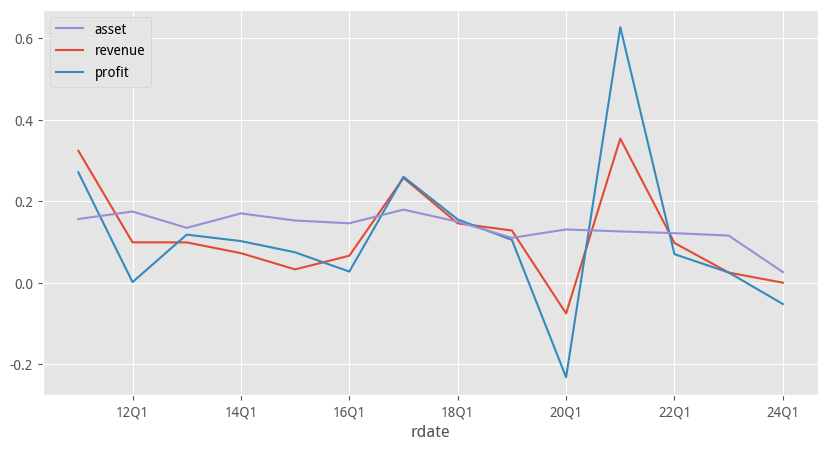

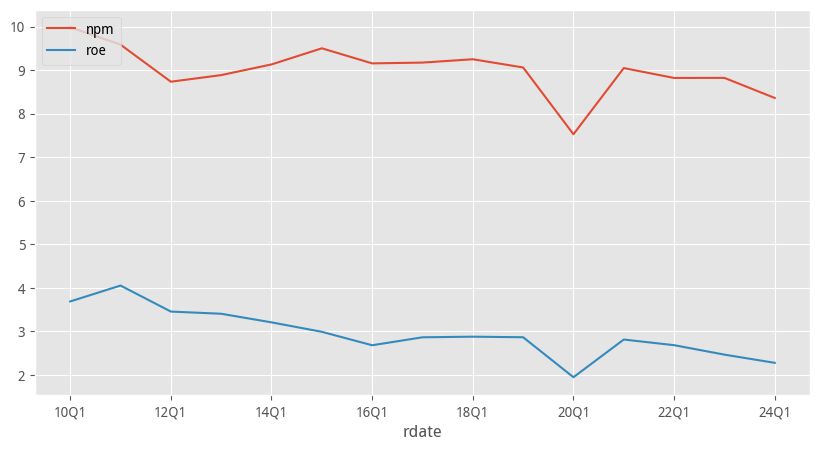

In [152]:
totals()

## 排名

In [153]:
q1tops = tops()

### 最近一年各项指标前20

In [154]:
q1tops[0]

,revenue,profit,asset,cash
0,中国石油,工商银行,工商银行,工商银行
1,中国石化,建设银行,建设银行,农业银行
2,中国建筑,农业银行,农业银行,邮储银行
3,中国铁建,中国银行,中国银行,建设银行
4,中国中铁,中国石油,中国石油,中国人寿
5,中国移动,中国海油,中国移动,中国石油
6,中国平安,招商银行,招商银行,中国银河
7,工商银行,中国平安,交通银行,宁波银行
8,建设银行,中国移动,中国平安,江苏银行
9,农业银行,邮储银行,邮储银行,中信证券


### 历年进入过前300

In [155]:
q1tops[1]()

revenue top 300: 556
profit top 300: 813
asset top 300: 622
cash top 300: 1119
top 300 in all cols: 311
total: 311 | from 15 to 1


,1,2,3,4,5,6,7,8,9,10
0,山东黄金,中远海控,金发科技,柳钢股份,格力电器,东方电气,比亚迪,本钢板材,太钢不锈,中国联通
1,中国铝业,TCL科技,上海医药,一汽解放,光大银行,云南铜业,海信视像,中国银行,四川长虹,国电电力
2,河钢股份,爱施德,平安银行,中国中铁,中国石化,中国中免,万华化学,中国铁建,中国东航,华电国际
3,江淮汽车,中集集团,中国电建,上海石化,山东钢铁,伊利股份,招商银行,南钢股份,三一重工,美的集团
4,中国石油,紫金矿业,福田汽车,国投电力,洋河股份,江西铜业,酒钢宏兴,广州发展,华锦股份,海尔智家
5,长安汽车,金隅集团,ST易购,中煤能源,中国神华,中国化学,海螺水泥,云南白药,长江电力,首钢股份
6,潍柴动力,中信银行,工商银行,中联重科,青岛啤酒,建发股份,大秦铁路,山西焦煤,南方航空,特变电工
7,双汇发展,铜陵有色,西部矿业,华夏银行,锡业股份,中兴通讯,中国人寿,华域汽车,兖矿能源,徐工机械
8,包钢股份,隧道股份,厦门国贸,中国太保,豫园股份,华能国际,大唐发电,宝钢股份,中国重汽,广汽集团
9,中信证券,民生银行,浦发银行,马钢股份,建设银行,鞍钢股份,上海电力,中金黄金,贵州茅台,农业银行


### 每年都进入前300

In [156]:
amount = q1tops[2]()

revenue all time top 300: 173
total: 173 | from 15 to 3


,1,2,3,4,5,6,7,8,9,10
0,东方创业,中远海控,中国电建,上海建工,上海石化,太钢不锈,鞍钢股份,美的集团,交通银行,华能国际
1,五矿发展,河钢股份,中国铝业,中国神华,中国中冶,中国太保,云天化,比亚迪,中兴通讯,海尔智家
2,福田汽车,上海电气,马钢股份,中国国航,大唐发电,潍柴动力,中国东航,中煤能源,招商银行,江西铜业
3,ST易购,南方航空,中国中免,兴业银行,大秦铁路,华域汽车,格力电器,本钢板材,华电国际,浦发银行
4,TCL科技,铜陵有色,中信银行,民生银行,中国中车,华菱钢铁,建发股份,广州发展,洋河股份,海亮股份
5,浙商中拓,华东医药,中化国际,中集集团,双汇发展,江淮汽车,一汽解放,百联股份,光大银行,酒钢宏兴
6,四川长虹,包钢股份,国电电力,新兴铸管,长安汽车,上海医药,首钢股份,厦门国贸,南钢股份,东方电气
7,物产中大,伊利股份,兖矿能源,柳钢股份,三一重工,新钢股份,山东钢铁,金发科技,锡业股份,广汽集团
8,万华化学,云南白药,华谊集团,云南铜业,天音控股,徐工机械,华夏银行,中联重科,安阳钢铁,山东黄金
9,中国重汽,海螺水泥,紫金矿业,中国化学,厦门信达,西部矿业,爱施德,永辉超市,豫园股份,长江电力


profit all time top 300: 101
total: 101 | from 15 to 3


,1,2,3,4,5,6,7,8,9,10
0,工商银行,建设银行,中国中冶,上港集团,贵州茅台,海通证券,华夏银行,广发证券,宝钢股份,光大银行
1,华泰证券,海螺水泥,招商证券,洋河股份,上汽集团,光大证券,中国化学,长江电力,宁波港,上海医药
2,海尔智家,宁波银行,福耀玻璃,中国核电,建发股份,电投能源,保利发展,南京银行,中国电建,格力电器
3,泸州老窖,特变电工,中国建筑,中国铁建,平安银行,潍柴动力,中国交建,中国银行,中国神华,中国电信
4,招商银行,中国平安,兖矿能源,北京银行,中国太保,大秦铁路,兴业银行,浦发银行,民生银行,中信银行
5,中信证券,中国人寿,中国中铁,伊利股份,美的集团,青岛啤酒,交通银行,农业银行,云南白药,雅戈尔
6,海康威视,恒瑞医药,山西汾酒,万华化学,双汇发展,华润三九,新华保险,浙能电力,海天味业,今世缘
7,国信证券,申万宏源,国泰君安,中国广核,贵阳银行,龙源电力,杭州银行,郑州银行,中国银河,江苏银行
8,上海银行,浙商银行,渝农商行,长沙银行,成都银行,邮储银行,青农商行,新天绿能,工业富联,西安银行
9,中国通号,苏州银行,青岛港,中国人保,中金公司,迈瑞医疗,青岛银行,中国海油,中国移动,东航物流


asset all time top 300: 187
total: 187 | from 15 to 3


,1,2,3,4,5,6,7,8,9,10
0,大秦铁路,光大银行,中国建筑,长江电力,中国铝业,鞍钢股份,中国中铁,中国铁建,兴业银行,中信证券
1,中国太保,中国联通,中国重工,中煤能源,中国平安,中远海发,中国国航,广深铁路,光大证券,太钢不锈
2,宁沪高速,保利发展,河钢股份,马钢股份,华夏银行,海螺水泥,华能国际,中远海控,上港集团,中国中冶
3,上汽集团,海通证券,广发证券,华电国际,上海电气,中海油服,平安银行,紫金矿业,中兴通讯,中国中车
4,华泰证券,国电电力,江西铜业,中远海能,申能股份,中集集团,中国船舶,深圳能源,华域汽车,中联重科
5,新兴铸管,南山铝业,包钢股份,潍柴动力,青岛啤酒,湖北能源,贵州茅台,雅戈尔,金地集团,格力电器
6,国元证券,南京银行,中国化学,山西焦煤,南方航空,三一重工,上海机场,东方电气,长江证券,山东高速
7,招商轮船,长安汽车,宁波银行,兖矿能源,潞安环能,海油工程,上海建工,云南白药,伊利股份,民生银行
8,中国石油,工商银行,豫园股份,浙江龙盛,隧道股份,招商银行,交通银行,中国神华,中国东航,中国人寿
9,中国银行,建设银行,农业银行,中国石化,中国中免,山东黄金,福耀玻璃,建发股份,川投能源,万华化学


cash all time top 300: 38
total: 38 | from 15 to 1


,1,2,3,4,5,6,7,8,9,10
0,国电电力,华电国际,紫金矿业,华能国际,深圳能源,长江电力,福耀玻璃,青岛啤酒,国投电力,北大荒
1,桂冠电力,中国人寿,中国联通,工商银行,中国太保,中国神华,万华化学,美的集团,蓝思科技,中国广核
2,中国核电,秦港股份,迈瑞医疗,鹏鼎控股,宝丰能源,财通证券,新天绿能,渝农商行,京沪高铁,中芯国际
3,三峡能源,龙源电力,菜百股份,中国移动,陕西能源,中国海油,华勤技术,龙旗科技,,


all time top 300 no cash: 60
total: 60 | from 15 to 4


,1,2,3,4,5,6,7,8,9,10
0,云南白药,中信银行,海螺水泥,平安银行,中国电建,浦发银行,宝钢股份,中国中冶,农业银行,海尔智家
1,洋河股份,招商银行,保利发展,中国化学,特变电工,中国神华,中国银行,兖矿能源,中国铁建,贵州茅台
2,中国电信,中国平安,中国建筑,中信证券,交通银行,中国交建,万华化学,民生银行,兴业银行,长江电力
3,中国太保,格力电器,中国中铁,光大银行,建设银行,伊利股份,大秦铁路,上汽集团,潍柴动力,中国人寿
4,建发股份,青岛啤酒,中国核电,美的集团,上海医药,华夏银行,工商银行,新华保险,浙能电力,国泰君安
5,中国广核,龙源电力,上海银行,江苏银行,浙商银行,工业富联,邮储银行,中国人保,中国移动,中国海油


all time top 300 in all cols: 13
total: 13 | from 15 to 4


,1,2,3,4,5,6,7,8,9,10
0,万华化学,美的集团,长江电力,中国核电,中国太保,中国神华,工商银行,青岛啤酒,中国人寿,中国广核
1,龙源电力,中国海油,中国移动,,,,,,,


## 增长情况
- 选择了有6期以上报告的公司。

In [157]:
inc = q1tops[3]()

,revenue,profit,asset,cash
0,英特集团,招商银行,中国银行,中国国贸
1,千金药业,北京银行,明星电力,复星医药
2,省广集团,中电环保,兴业银行,片仔癀
3,广安爱众,南京银行,洋河股份,渤海租赁
4,兴森科技,美的集团,华润双鹤,恩华药业
5,招商银行,中信银行,建设银行,北大荒
6,云南白药,唐山港,农业银行,西藏药业
7,国药一致,京新药业,大秦铁路,旺能环境
8,卧龙电驱,中国建筑,铁龙物流,广汇能源
9,南京银行,兴业银行,深圳燃气,济川药业


slope top 300 no cash: 65
total: 65 | from 1.3394130202131267 to 0.5723652335755595


,1,2,3,4,5,6,7,8,9,10
0,招商银行,国药一致,卧龙电驱,南京银行,上海医药,海格通信,数字政通,羚锐制药,海康威视,老板电器
1,华东医药,京新药业,平安银行,中国国贸,兴业银行,华海药业,广电运通,南京医药,物产中大,华夏银行
2,中国银行,中国建筑,安科生物,龙净环保,兴蓉环境,伟星新材,老凤祥,福能股份,贵州茅台,洋河股份
3,沃尔核材,光大银行,瀚蓝环境,康缘药业,保利发展,农业银行,丰原药业,福耀玻璃,恒瑞医药,普洛药业
4,昆药集团,鱼跃医疗,东南网架,江苏神通,回天新材,交通银行,国药股份,航天电子,顺络电子,联环药业
5,银轮股份,白云山,长江电力,永新股份,仁和药业,中信证券,中国中铁,国投电力,中国铁建,明星电力
6,建设银行,中电环保,吉电股份,海亮股份,亚太科技,,,,,


slope top 300 in all cols: 19
total: 19 | from 1.3030233491929641 to 0.5754436082884925


,1,2,3,4,5,6,7,8,9,10
0,卧龙电驱,羚锐制药,京新药业,中国国贸,华海药业,安科生物,老凤祥,沃尔核材,福耀玻璃,普洛药业
1,鱼跃医疗,回天新材,顺络电子,长江电力,中信证券,国投电力,明星电力,建设银行,吉电股份,


- 净利率的增长不太能说明问题。总体来看均值和中位数变动不大。

## 金额和增长
- 不计算cash, 金额每年都进入前300, 增长也进入前300。

In [158]:
yjbb.fold_a_col(cross_index([amount, inc]).iloc[:,0], show_num=False)

total: 18 | from 15 to 15


,1,2,3,4,5,6,7,8,9,10
0,农业银行,平安银行,中国铁建,贵州茅台,长江电力,交通银行,中信证券,中国建筑,中国中铁,建设银行
1,招商银行,保利发展,洋河股份,上海医药,光大银行,兴业银行,中国银行,华夏银行,,


- ROE高，同时ROE平均增长还高的，果然没有任何大金融。

In [159]:
import nbformat as nbf
from pathlib import Path
def remove_input():
    fn = Path('2024q1.ipynb')
    nb = nbf.read(fn, nbf.NO_CONVERT)
    for cell in nb.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        if not 'remove_input' in cell_tags:
            cell_tags.append('remove_input')
            cell['metadata']['tags'] = cell_tags
    nbf.write(nb, fn)
remove_input()